In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
#Set options for seaborn and pandas
sns.set()
pd.set_option("display.max_columns", 30)

In [3]:
#Dataset obtained from https://webrobots.io/kickstarter-datasets/
#in JSON streaming format
fname = "dataset/kickstarter_dataset.json"
projects = []
with open(fname) as datafile:
    #Every line is a separate kickstarter campaign (JSON document)
    line = datafile.readline().strip()
    while line:
        if line:
            #Load the JSON document
            project = json.loads(line)
            project = project["data"]
            #Pop (remove) any variables that aren't of interest
            project.pop("photo")
            project.pop("slug")
            project.pop("currency_symbol")
            project.pop("currency_trailing_code")
            project.pop("creator")
            project.pop("static_usd_rate")
            project["category"] = project["category"]["slug"]
            project.pop("profile")
            project.pop("urls")
            project.pop("source_url")
            project.pop("usd_type")
            project.pop("fx_rate")
            project.pop("created_at")
            project.pop("state_changed_at")
            #Append the campaign to a list
            projects.append(project)
            line = datafile.readline().strip()

In [4]:
#Create a dataframe from the campaigns
df = pd.DataFrame(projects)
#Drop some more columns that don't appear in all campaigns
df = df.drop(["friends", "permissions", "is_starrable", "is_starred", "is_backing", "spotlight", "staff_pick", "location", "converted_pledged_amount", "current_currency", "disable_communication"], axis=1)

In [5]:
#The method of webscraping introduces some duplicate campaigns.
#Get rid of them using their IDs
df = df.drop_duplicates(subset=["id"])

In [6]:
#Taking care of the data-types
df["id"] = df["id"].astype("str")
df["usd_pledged"] = df["usd_pledged"].astype("float")

In [7]:
#Date-time are in unix timestamps, make them human readable
df["deadline"] = pd.to_datetime(df["deadline"], unit="s")
df["launched_at"] = pd.to_datetime(df["launched_at"], unit="s")

In [8]:
#Too many sub-categories, reduce them to main categories
df["category"] = df["category"].apply(lambda x: x.split("/")[0])
df["category"] = df["category"].astype("category")

In [9]:
#Campaign length
df["campaign_length"] = (df["deadline"] - df["launched_at"]).dt.days
#How much of the goal achieved
df["achievement"] = df["pledged"] / df["goal"]

In [10]:
df["currency"] = df["currency"].astype("category")

In [11]:
#Only the failed and successful campaigns are considered
df_live = df[df["state"] == "live"].copy()
df = df[np.logical_or((df["state"] == "failed"), df["state"] == "successful")]

In [12]:
df["state"] = df["state"].astype("category")
df_live["state"] = df_live["state"].astype("category")

In [13]:
df.head()

,backers_count,blurb,category,country,currency,deadline,goal,id,launched_at,name,pledged,state,usd_pledged,campaign_length,achievement
0,1,Jozii is the premier service for full-time uni...,technology,US,USD,2014-11-28 04:59:00,3500.0,895922629,2014-10-28 19:42:54,Jozii-College Jobs Made Easy,50.00,failed,50.000000,30,0.014286
1,63,Dropsy is an adventure game with a focus on ex...,games,US,USD,2011-11-02 18:39:11,225.0,1190376005,2011-10-17 18:39:11,DROPSY: A different take on the old school adv...,1613.47,successful,1613.470000,16,7.170978
2,113,We've bought a press and already found a studi...,publishing,US,USD,2014-09-12 06:12:18,6500.0,672906219,2014-08-13 06:12:18,Letra Chueca / Crooked Letter: a printshop & b...,6633.00,successful,6633.000000,30,1.020462
3,1,"Premium, fashion sneaker brand intertwining hi...",fashion,GB,GBP,2016-05-03 20:04:16,15000.0,2121203785,2016-03-04 21:04:16,High End Premium Handmade Sneakers,1.00,failed,1.407899,59,0.000067
4,99,Made in Europe from the finest quality leather...,fashion,CA,CAD,2015-04-22 05:01:38,15000.0,434454655,2015-03-18 05:01:38,The Domenico Sneakerboot by Luigi Sardo Shoes,25338.00,successful,19817.405716,35,1.689200


In [14]:
df.dtypes

backers_count               int64
blurb                      object
category                 category
country                    object
currency                 category
deadline           datetime64[ns]
goal                      float64
id                         object
launched_at        datetime64[ns]
name                       object
pledged                   float64
state                    category
usd_pledged               float64
campaign_length             int64
achievement               float64
dtype: object

In [15]:
print("Total projects:", df.shape[0])
print("Successful projects:", (df[df["state"] == "successful"]).shape[0])
print("Failed projects:", (df[df["state"] == "failed"]).shape[0])

Total projects: 173886
Successful projects: 99464
Failed projects: 74422


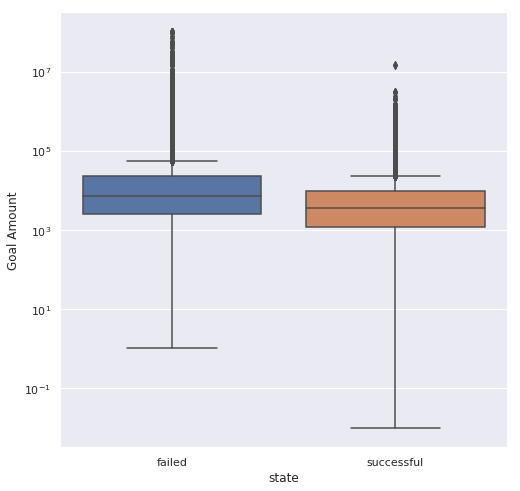

In [16]:
goal_plot = sns.boxplot(data=df, x="state", y="goal", orient="vertical")
goal_plot.figure.set_size_inches(8, 8)
goal_plot.axes.set_yscale("log")
goal_plot.set_ylabel("Goal Amount")
plt.show()

Successful campaigns tend to have a lower goal amount. Notice that the y-scale is logarithmic.

In [17]:
stats.ttest_ind(df[df["state"] == "failed"]["goal"], df[df["state"] == "successful"]["goal"])

Ttest_indResult(statistic=14.341902917316457, pvalue=1.273048152669014e-46)

In [18]:
print("Mean goal among failed campaigns", np.mean(df[df["state"] == "failed"]["goal"]))
print("Mean goal among successful campaigns", np.mean(df[df["state"] == "successful"]["goal"]))

Mean goal among failed campaigns 87160.02970317917
Mean goal among successful campaigns 10346.239174475191


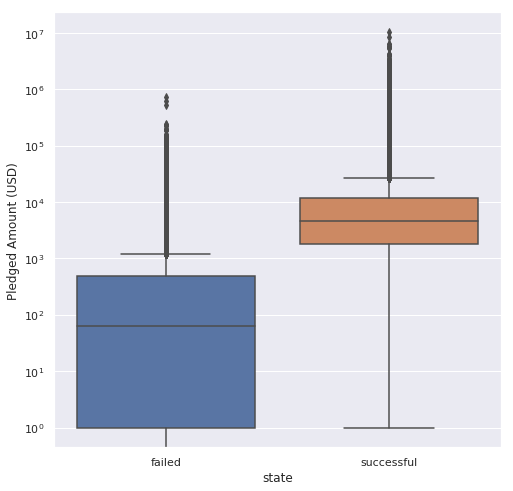

In [23]:
pledge_plot = sns.boxplot(data=df, x="state", y="usd_pledged", orient="vertical")
pledge_plot.figure.set_size_inches(8, 8)
pledge_plot.axes.set_yscale("log")
pledge_plot.set_ylabel("Pledged Amount (USD)")
plt.show()

Successful campaigns have much higher amount pledged by backers. Again, the y-scale is logarithmic.  
Which means orders of magnitude more amount is pledged to successful campaigns compared to failed ones.

In [24]:
stats.ttest_ind(df[df["state"] == "failed"]["usd_pledged"], df[df["state"] == "successful"]["usd_pledged"])

Ttest_indResult(statistic=-44.63158041269377, pvalue=0.0)

In [25]:
print("Mean pledged amount among failed campaigns", np.mean(df[df["state"] == "failed"]["usd_pledged"]))
print("Mean pledged amount among successful campaigns", np.mean(df[df["state"] == "successful"]["usd_pledged"]))

Mean pledged amount among failed campaigns 1157.0520787530152
Mean pledged amount among successful campaigns 19159.71023293669


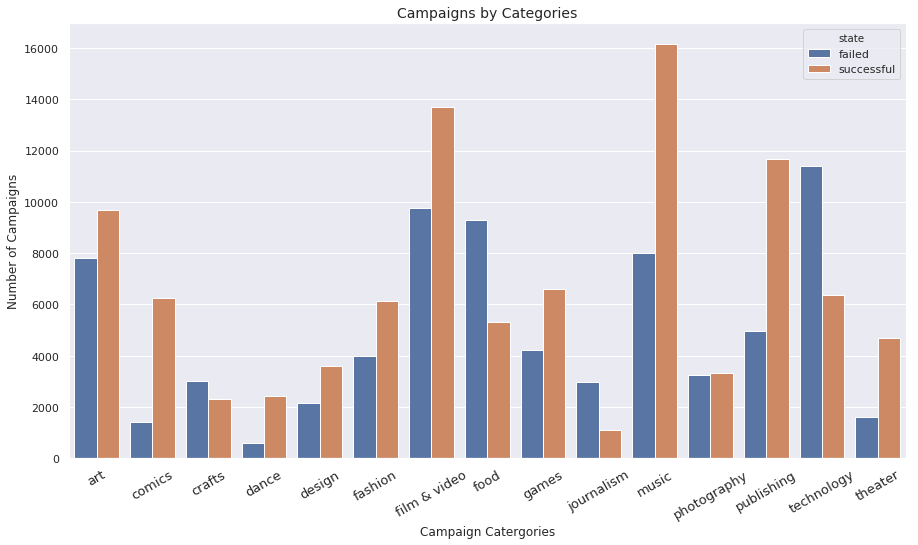

In [26]:
cat_state_plot_data = df.groupby(["category", "state"]).size().reset_index(name="counts")
cat_state_plot = sns.barplot(data=cat_state_plot_data, x="category", y="counts", hue="state")
cat_state_plot.figure.set_size_inches(15, 8)
cat_state_plot.set_xticklabels(cat_state_plot.get_xticklabels(), rotation=30, fontdict={"size": 13})
cat_state_plot.set_title("Campaigns by Categories", fontdict={"size": 14})
cat_state_plot.set_xlabel("Campaign Catergories")
cat_state_plot.set_ylabel("Number of Campaigns")
plt.show()

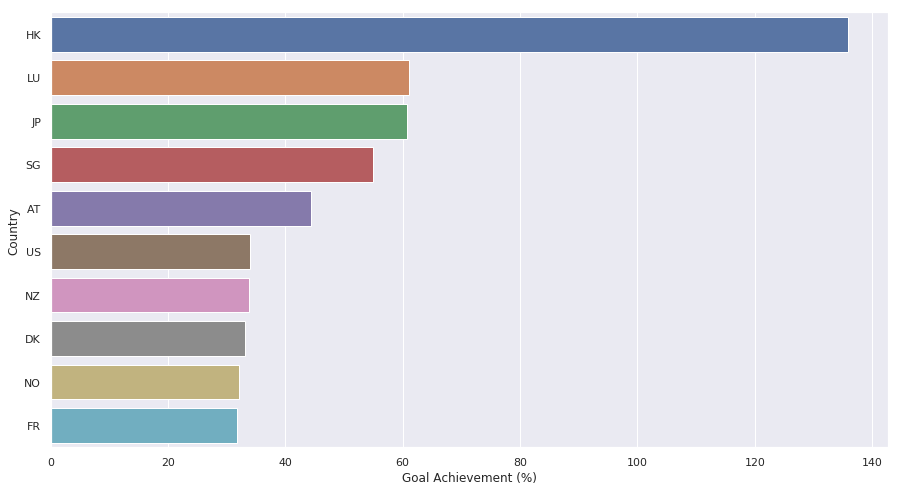

In [27]:
country_goal_achievement = df[["country", "goal", "pledged"]].dropna()
country_goal_achievement = country_goal_achievement.groupby(["country"]).sum().reset_index()
country_goal_achievement["achievement"] = country_goal_achievement["pledged"] / country_goal_achievement["goal"] * 100
country_goal_achievement = country_goal_achievement.sort_values(ascending=False, by="achievement")
country_goal_achievement_plot = sns.barplot(data=country_goal_achievement[:10], x="achievement", y="country")
country_goal_achievement_plot.figure.set_size_inches(15, 8)
country_goal_achievement_plot.set_ylabel("Country")
country_goal_achievement_plot.set_xlabel("Goal Achievement (%)")
plt.show()

Hong Kong is by far the most successful country by goal amount achieved. It is followed by Luxembourg and Japan, both close together. Values higher than 100 mean that several campaigns achieved their goals and even surpassed them.

In [28]:
df.sort_values(ascending=False, by="usd_pledged")[["name", "category", "usd_pledged", "state"]].head(10)

,name,category,usd_pledged,state
80539,Pebble: E-Paper Watch for iPhone and Android,design,10266845.74,successful
179857,OUYA: A New Kind of Video Game Console,games,8596474.58,successful
114940,Shenmue 3,games,6333295.77,successful
117964,Pono Music - Where Your Soul Rediscovers Music,technology,6225354.98,successful
68972,Bring Back MYSTERY SCIENCE THEATER 3000,film & video,5764229.38,successful
150213,The Veronica Mars Movie Project,film & video,5702153.38,successful
78658,Bloodstained: Ritual of the Night,games,5545991.70,successful
69279,"Bring Reading Rainbow Back for Every Child, Ev...",technology,5408916.95,successful
177572,ZeTime: World's first smartwatch with hands ov...,technology,5333792.84,successful
41233,Pimax: The World's First 8K VR Headset,technology,4236618.49,successful


Top 10 campaigns by amount pledged.

In [29]:
df.sort_values(ascending=False, by="backers_count")[["name", "category", "backers_count", "state", "usd_pledged"]].head(10)

,name,category,backers_count,state,usd_pledged
69279,"Bring Reading Rainbow Back for Every Child, Ev...",technology,105857,successful,5.408917e+06
150213,The Veronica Mars Movie Project,film & video,91585,successful,5.702153e+06
13732,Double Fine Adventure,games,87142,successful,3.336372e+06
129025,Torment: Tides of Numenera,games,74405,successful,4.188927e+06
141451,Project Eternity,games,73986,successful,3.986929e+06
174366,Yooka-Laylee - A 3D Platformer Rare-vival!,games,73206,successful,3.225225e+06
114940,Shenmue 3,games,69320,successful,6.333296e+06
80539,Pebble: E-Paper Watch for iPhone and Android,design,68929,successful,1.026685e+07
72627,Mighty No. 9,games,67226,successful,3.845171e+06
78658,Bloodstained: Ritual of the Night,games,64867,successful,5.545992e+06


Top 10 campaigns by number of backers

In [30]:
df.sort_values(ascending=False, by="achievement")[["name", "category", "achievement", "state", "usd_pledged"]].head(10)

,name,category,achievement,state,usd_pledged
92715,Energy Hook,games,41535.010,successful,41535.01
170303,Tim Rose Visual Album: <3,film & video,28688.180,successful,28688.18
152898,CLOCKWRIGHT: Large-Scale Analogue Time Machines,art,27588.230,successful,27588.23
167363,"Penny Arcade's Podcast, ""Downloadable Content""...",publishing,23036.067,successful,230360.67
195518,THE 'mi8' RISES | The Best Wireless Duo Stereo...,technology,22603.000,successful,22603.00
119921,Y (A Generation),film & video,15066.000,successful,15066.00
70578,"Multi-Purpose, All-Occasion Greeting Cards",crafts,12575.150,successful,25150.30
37400,LOVELAND Round 6: A Force More Powerful,art,10000.000,successful,100.00
183520,"Arduino IoT. Home automation, 3D printing, rob...",technology,9605.000,successful,9605.00
173522,Dice Set Felt Coasters,games,7548.000,successful,7548.00


Top 10 campaigns by achievement

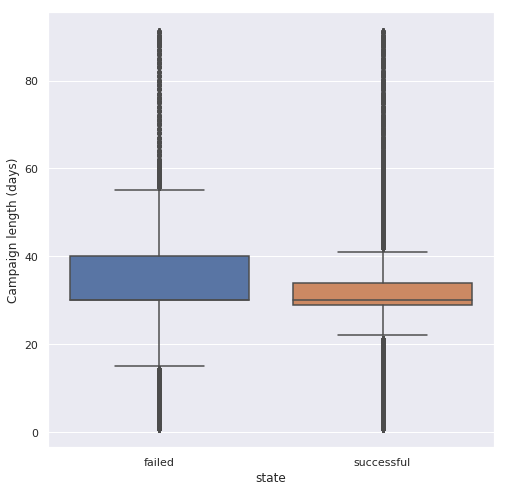

In [31]:
campaign_length_plot = sns.boxplot(data=df, x="state", y="campaign_length")
campaign_length_plot.figure.set_size_inches(8, 8)
campaign_length_plot.set_ylabel("Campaign length (days)")
plt.show()

Successful campaigns seem to have a narrower distribution with a lower mean campaign length. The median value appears to be almost same for both failed and successful campaigns.

In [32]:
stats.ttest_ind(df[df["state"] == "failed"]["campaign_length"], df[df["state"] == "successful"]["campaign_length"])

Ttest_indResult(statistic=41.18139553638472, pvalue=0.0)

In [33]:
print("Mean campaign duration among failed campaigns", np.mean(df[df["state"] == "failed"]["campaign_length"]))
print("Mean campaign duration among successful campaigns", np.mean(df[df["state"] == "successful"]["campaign_length"]))

Mean campaign duration among failed campaigns 34.71372712369998
Mean campaign duration among successful campaigns 32.21793814847583


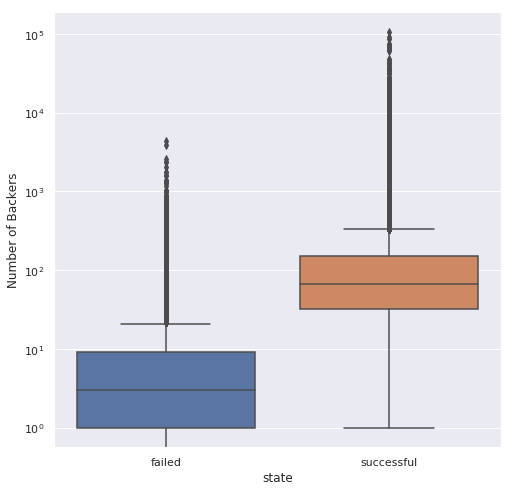

In [34]:
backer_plot = sns.boxplot(data=df, x="state", y="backers_count")
backer_plot.figure.set_size_inches(8, 8)
backer_plot.set_ylabel("Number of Backers")
backer_plot.axes.set_yscale("log")
plt.show()

Successful campaigns are supported by much more people, as one would expect. The y-scale is again logarithmic.

In [35]:
stats.ttest_ind(df[df["state"] == "failed"]["backers_count"], df[df["state"] == "successful"]["backers_count"])

Ttest_indResult(statistic=-48.36647980437488, pvalue=0.0)

In [36]:
print("Mean number of backers among failed campaigns", np.mean(df[df["state"] == "failed"]["backers_count"]))
print("Mean number of backers among successful campaigns", np.mean(df[df["state"] == "successful"]["backers_count"]))

Mean number of backers among failed campaigns 13.10963156056005
Mean number of backers among successful campaigns 232.360803908952


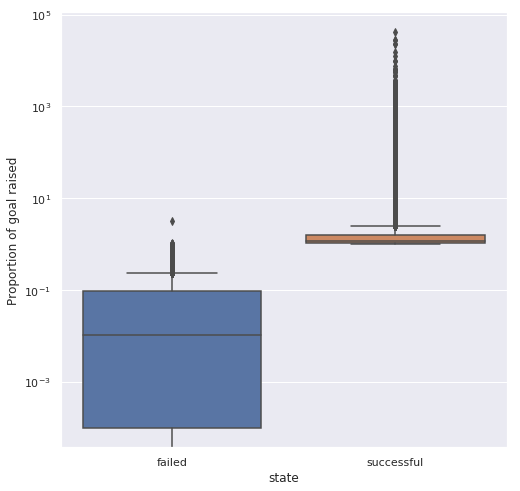

In [37]:
achievement_plot = sns.boxplot(data=df, x="state", y="achievement")
achievement_plot.figure.set_size_inches(8, 8)
achievement_plot.set_ylabel("Proportion of goal raised")
achievement_plot.axes.set_yscale("log")
plt.show()

In [38]:
stats.ttest_ind(df[df["state"] == "failed"]["achievement"], df[df["state"] == "successful"]["achievement"])

Ttest_indResult(statistic=-6.951469190833243, pvalue=3.627667897132902e-12)

In [39]:
print("Mean achievement among failed campaigns", np.mean(df[df["state"] == "failed"]["achievement"]))
print("Mean achievement among successful campaigns", np.mean(df[df["state"] == "successful"]["achievement"]))

Mean achievement among failed campaigns 0.08142467322681181
Mean achievement among successful campaigns 6.100125066188743


In [42]:
df[df["state"] == "successful"]["achievement"].describe()

count    99464.000000
mean         6.100125
std        236.198108
min          0.999830
25%          1.046476
50%          1.164367
75%          1.593342
max      41535.010000
Name: achievement, dtype: float64

Based on the EDA, create a logistic regression model to predict the fate of the campaign (success/fail).

The predictor variables are number of backers, length of the campaign, category and country of the campaign.

In [43]:
X = df[["goal", "backers_count", "campaign_length", "category", "country"]].copy()
y = df["state"].copy()
enc = LabelEncoder()
enc.fit(X["category"])
X["category"] = enc.transform(X["category"])
enc = LabelEncoder()
enc.fit(X["country"])
X["country"] = enc.transform(X["country"])

Split the data into training and testing sets

In [44]:
#Fixed seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19284692)

In [45]:
classifier = LogisticRegression(random_state=19284692, solver="lbfgs", max_iter=200).fit(X_train, y_train)

In [46]:
print("Mean accuracy: {:.4f}".format(classifier.score(X_test, y_test)))

Mean accuracy: 0.8963


In [47]:
print("ROC area under the curve: {:.2f}".format(roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])))

ROC area under the curve: 0.96


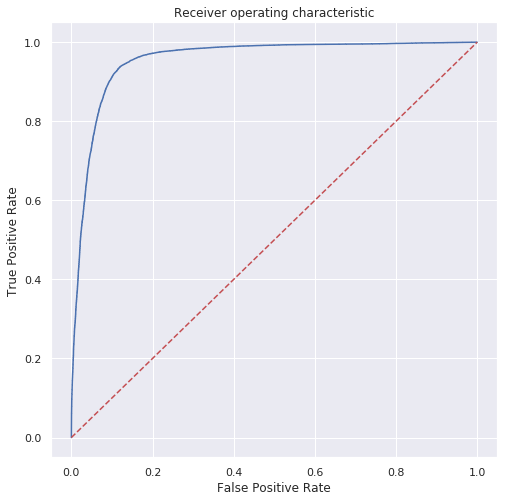

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1], pos_label="successful")
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()

In [49]:
print(classifier.intercept_, classifier.coef_)

[-0.74337185] [[-7.48141003e-05  5.16048362e-02 -1.31678384e-02 -1.03979149e-02
   2.32308284e-02]]
